In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import pandas as pd
import joblib

import os
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

import pathlib
DATA_DIR = pathlib.Path.cwd()/'data/input'
OUT_DIR = pathlib.Path.cwd()/'data/output'

from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.utils import resample

import lightgbm as lgb
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence

import sys 
sys.path.append(str(pathlib.Path.cwd()/'utils'))
from utils.misc_utils import fullrange, realized_volatility, log_return, rmspe, get_stock_path, load_parquet_file, load_parquet_files, load_train_test

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [3]:
final_training_data = pd.read_pickle(OUT_DIR/'final_training_data_finer_buckets.pkl')
final_test_data = pd.read_pickle(OUT_DIR/'final_test_data_finer_buckets.pkl')
#final_training_data = final_training_data.dropna(axis=1)

In [4]:
model_col = [col for col in final_training_data.columns if ('id' not in col) & ('target' not in col)]

X_train, X_test, y_train, y_test = train_test_split(
                                        final_training_data.drop('target', axis=1)[model_col],
                                        final_training_data['target'],
                                        test_size=0.1
                                        )

X_train, X_valid, y_train, y_valid = train_test_split(
                                        X_train,
                                        y_train,
                                        test_size=0.1
                                        )


In [5]:
final_training_data.head()

,id,time_id,stock_id,target,wap1_mean_0_100,wap1_std_0_100,wap1_fullrange_0_100,wap2_mean_0_100,wap2_std_0_100,wap2_fullrange_0_100,...,log_return_1_realized_volatility_std_stock_500_600,log_return_2_realized_volatility_std_stock_500_600,log_return_1_sum_std_stock_500_600,log_return_2_sum_std_stock_500_600,volume_mean_mean_stock_500_600,volume_mean_std_stock_500_600,price_mean_mean_stock_500_600,price_mean_std_stock_500_600,order_count_mean_mean_stock_500_600,order_count_mean_std_stock_500_600
0,0-5,5,0,0.004136,1.002747,0.001098,0.002706,1.002567,0.001100,0.002806,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
1,0-11,11,0,0.001445,0.999884,0.000131,0.000315,0.999922,0.000136,0.000437,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
2,0-16,16,0,0.002168,1.000159,0.000176,0.000643,1.000170,0.000352,0.001319,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
3,0-31,31,0,0.002195,1.000312,0.000112,0.000399,0.999829,0.000109,0.000377,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
4,0-62,62,0,0.001747,0.999660,0.000320,0.000915,0.999598,0.000375,0.001147,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994


In [6]:
final_training_data.shape

(428932, 364)

## Model Training 

In [7]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
rmspe(y_test, xgb.predict(X_test))

0.2500613849421239

In [8]:
import numpy as np
import lightgbm as lgb

def rmspe_obj(
    prediction,
    train
    ):
    y = train.get_label()
    grad = -2*(y-prediction)/(y**2)
    hess = 2/(y**2)
    return grad, hess

def rmspe_eval(
    prediction,
    train
    ):
    y = train.get_label()
    rmspe =  (np.sqrt(np.mean(np.square((y - prediction) / y))))
    return 'rmspe', rmspe, False

In [9]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)
test_data = lgb.Dataset(X_test, label=y_test)


parameters = {'verbosity': -1,
                'n_jobs': -1,
                'seed': 123}

model = lgb.train(parameters,
                       train_data,
                       valid_sets=valid_data,
                       fobj = rmspe_obj,
                       feval = rmspe_eval,
                       num_boost_round=50000,
                       early_stopping_rounds=200)

rmspe(y_test, model.predict(X_test))

[1]	valid_0's rmspe: 0.907959
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmspe: 0.825657
[3]	valid_0's rmspe: 0.752006
[4]	valid_0's rmspe: 0.686539
[5]	valid_0's rmspe: 0.628192
[6]	valid_0's rmspe: 0.576356
[7]	valid_0's rmspe: 0.530418
[8]	valid_0's rmspe: 0.48992
[9]	valid_0's rmspe: 0.454228
[10]	valid_0's rmspe: 0.422957
[11]	valid_0's rmspe: 0.395546
[12]	valid_0's rmspe: 0.371645
[13]	valid_0's rmspe: 0.350885
[14]	valid_0's rmspe: 0.333015
[15]	valid_0's rmspe: 0.317346
[16]	valid_0's rmspe: 0.304026
[17]	valid_0's rmspe: 0.292593
[18]	valid_0's rmspe: 0.282712
[19]	valid_0's rmspe: 0.274376
[20]	valid_0's rmspe: 0.26721
[21]	valid_0's rmspe: 0.261039
[22]	valid_0's rmspe: 0.255804
[23]	valid_0's rmspe: 0.251307
[24]	valid_0's rmspe: 0.247375
[25]	valid_0's rmspe: 0.244113
[26]	valid_0's rmspe: 0.241247
[27]	valid_0's rmspe: 0.238771
[28]	valid_0's rmspe: 0.236699
[29]	valid_0's rmspe: 0.234887
[30]	valid_0's rmspe: 0.233098
[31]	valid_0's rmsp

0.20299130815783495

## Feature Importance

In [10]:
import shap
shap.initjs()

In [11]:
explainer_lgbm = shap.KernelExplainer(model.predict, shap.sample(X_test, 100))
shap_values_lgbm = explainer_lgbm.shap_values(shap.sample(X_test, 100), nsamples=500)

100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


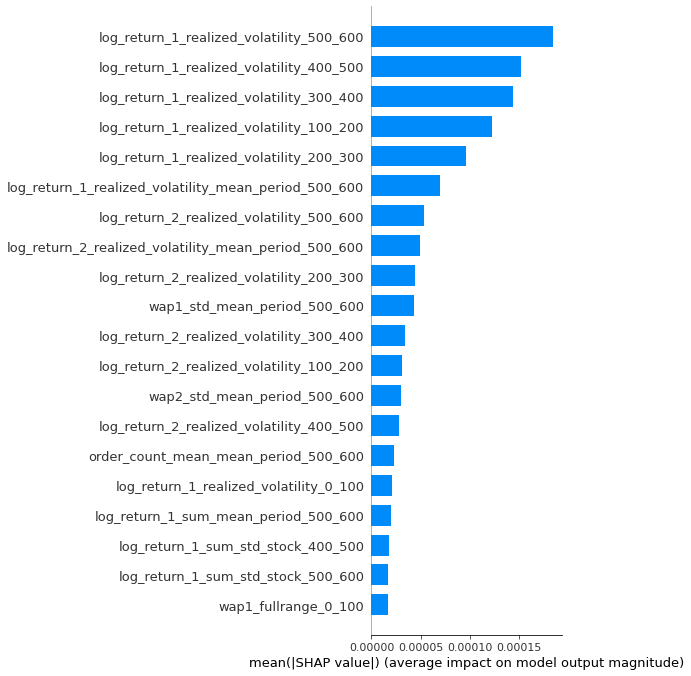

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(shap_values_lgbm, shap.sample(X_test, 100), plot_type="bar", auto_size_plot=False, show=False)
plt.tight_layout()

In [13]:
vals= np.abs(shap_values_lgbm).mean(0)

feature_importance = pd.DataFrame(list(zip(X_test.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

In [14]:
num_features = 30
selected_features = list(feature_importance.col_name)[:num_features]
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
                                        final_training_data.drop('target', axis=1)[selected_features],
                                        final_training_data['target'],
                                        test_size=0.1
                                        )

X_train_shap, X_valid_shap, y_train_shap, y_valid_shap = train_test_split(
                                        X_train_shap,
                                        y_train_shap,
                                        test_size=0.1
                                        )


In [15]:
train_data_shap = lgb.Dataset(X_train_shap, label=y_train_shap)
valid_data_shap = lgb.Dataset(X_valid_shap, label=y_valid_shap)
test_data_shap = lgb.Dataset(X_test_shap, label=y_test_shap)


parameters = {'verbosity': -1,
                'n_jobs': -1,
                'seed': 123}

model = lgb.train(parameters,
                       train_data_shap,
                       valid_sets=valid_data_shap,
                       fobj = rmspe_obj,
                       feval = rmspe_eval,
                       num_boost_round=50000,
                       early_stopping_rounds=200)

rmspe(y_test_shap, model.predict(X_test_shap))

[1]	valid_0's rmspe: 0.907968
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmspe: 0.825664
[3]	valid_0's rmspe: 0.75217
[4]	valid_0's rmspe: 0.686605
[5]	valid_0's rmspe: 0.628276
[6]	valid_0's rmspe: 0.576519
[7]	valid_0's rmspe: 0.530824
[8]	valid_0's rmspe: 0.490374
[9]	valid_0's rmspe: 0.454892
[10]	valid_0's rmspe: 0.42374
[11]	valid_0's rmspe: 0.396551
[12]	valid_0's rmspe: 0.372839
[13]	valid_0's rmspe: 0.352171
[14]	valid_0's rmspe: 0.334336
[15]	valid_0's rmspe: 0.319136
[16]	valid_0's rmspe: 0.30591
[17]	valid_0's rmspe: 0.294738
[18]	valid_0's rmspe: 0.285189
[19]	valid_0's rmspe: 0.277115
[20]	valid_0's rmspe: 0.270147
[21]	valid_0's rmspe: 0.264289
[22]	valid_0's rmspe: 0.259297
[23]	valid_0's rmspe: 0.255077
[24]	valid_0's rmspe: 0.251519
[25]	valid_0's rmspe: 0.248595
[26]	valid_0's rmspe: 0.245866
[27]	valid_0's rmspe: 0.243649
[28]	valid_0's rmspe: 0.241687
[29]	valid_0's rmspe: 0.2401
[30]	valid_0's rmspe: 0.238679
[31]	valid_0's rmspe: 

0.1962851067436792

### LOFO Importance

In [16]:
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.metrics import make_scorer

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)


In [17]:
# extract a sample of the data
sample_df = X_test.copy() 
sample_df['target'] = y_test
sample_df = sample_df.sample(frac=0.01, random_state=0)
cv = KFold(n_splits=4, shuffle=True, random_state=0)
# define the binary target and the features
dataset = Dataset(df=sample_df, target="target", features=[col for col in sample_df.columns if col != 'target'])
# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring=rmspe_scorer)
# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()
# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
 61%|██████    | 176/288 [04:35<03:00,  1.61s/it]

In [ ]:
selected_lofo_features = importance_df.loc[importance_df.importance_mean>0.001]['feature'].to_list()
X_train_lofo, X_test_lofo, y_train_lofo, y_test_lofo = train_test_split(
                                        final_training_data.drop('target', axis=1)[selected_lofo_features],
                                        final_training_data['target'],
                                        test_size=0.1
                                        )

X_train_lofo, X_valid_lofo, y_train_lofo, y_valid_lofo = train_test_split(
                                        X_train_lofo,
                                        y_train_lofo,
                                        test_size=0.1
                                        )

train_data_lofo = lgb.Dataset(X_train_lofo, label=y_train_lofo)
valid_data_lofo = lgb.Dataset(X_valid_lofo, label=y_valid_lofo)
test_data_lofo = lgb.Dataset(X_test_lofo, label=y_test_lofo)


parameters = {'verbosity': -1,
                'n_jobs': -1,
                'seed': 123}

model = lgb.train(parameters,
                       train_data_lofo,
                       valid_sets=valid_data_lofo,
                       fobj = rmspe_obj,
                       feval = rmspe_eval,
                       num_boost_round=50000,
                       early_stopping_rounds=200)

rmspe(y_test_lofo, model.predict(X_test_lofo))

[1]	valid_0's rmspe: 0.907813
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmspe: 0.825427
[3]	valid_0's rmspe: 0.751737
[4]	valid_0's rmspe: 0.686016
[5]	valid_0's rmspe: 0.627532
[6]	valid_0's rmspe: 0.575629
[7]	valid_0's rmspe: 0.529587
[8]	valid_0's rmspe: 0.488907
[9]	valid_0's rmspe: 0.453213
[10]	valid_0's rmspe: 0.421706
[11]	valid_0's rmspe: 0.394202
[12]	valid_0's rmspe: 0.370198
[13]	valid_0's rmspe: 0.349394
[14]	valid_0's rmspe: 0.33141
[15]	valid_0's rmspe: 0.315804
[16]	valid_0's rmspe: 0.30243
[17]	valid_0's rmspe: 0.291178
[18]	valid_0's rmspe: 0.281432
[19]	valid_0's rmspe: 0.273178
[20]	valid_0's rmspe: 0.266133
[21]	valid_0's rmspe: 0.260099
[22]	valid_0's rmspe: 0.255036
[23]	valid_0's rmspe: 0.250757
[24]	valid_0's rmspe: 0.247101
[25]	valid_0's rmspe: 0.243974
[26]	valid_0's rmspe: 0.24134
[27]	valid_0's rmspe: 0.239111
[28]	valid_0's rmspe: 0.237197
[29]	valid_0's rmspe: 0.235484
[30]	valid_0's rmspe: 0.234105
[31]	valid_0's rmspe

0.2045292945277715

In [ ]:
stock_id_list = final_training_data.stock_id.unique()

#for idx in stock_id_list:
    
stock_id_index = final_training_data.loc[final_training_data.stock_id==0].index

In [ ]:
X_test.loc[X_test.index.isin(stock_id_index)]

,wap1_mean_0_100,wap1_std_0_100,wap1_fullrange_0_100,wap2_mean_0_100,wap2_std_0_100,wap2_fullrange_0_100,log_return_1_fullrange_0_100,log_return_1_sum_0_100,log_return_1_mean_0_100,log_return_1_realized_volatility_0_100,...,log_return_1_realized_volatility_std_stock_500_600,log_return_2_realized_volatility_std_stock_500_600,log_return_1_sum_std_stock_500_600,log_return_2_sum_std_stock_500_600,volume_mean_mean_stock_500_600,volume_mean_std_stock_500_600,price_mean_mean_stock_500_600,price_mean_std_stock_500_600,order_count_mean_mean_stock_500_600,order_count_mean_std_stock_500_600
3494,1.001803,0.000790,0.002745,1.001582,0.001190,0.003602,0.008564,0.005693,0.000124,0.007882,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
204,0.999616,0.000314,0.000781,0.999437,0.000431,0.001408,0.001894,0.001066,0.000020,0.002029,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
544,1.000319,0.001313,0.004873,1.000927,0.001332,0.004821,0.006300,-0.007616,-0.000282,0.007021,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
2559,1.000028,0.000409,0.001346,0.999964,0.000467,0.001678,0.002508,0.002867,0.000067,0.002452,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
2784,0.999434,0.000549,0.002421,0.999342,0.000413,0.001670,0.001993,-0.003344,-0.000104,0.002285,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.999635,0.000257,0.001010,0.999625,0.000264,0.000863,0.004165,-0.003863,-0.000107,0.003954,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
3230,1.000085,0.000354,0.001458,1.000373,0.000340,0.001814,0.002306,-0.000359,-0.000015,0.001914,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
1874,0.994563,0.001629,0.005505,0.994748,0.001560,0.006163,0.010956,-0.007600,-0.000317,0.010022,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994
2239,0.999920,0.000335,0.001234,1.000030,0.000303,0.001500,0.010818,-0.009636,-0.000182,0.010459,...,0.001376,0.001908,0.001251,0.001361,99.670937,90.517441,0.974452,0.157978,3.162263,1.998994


In [ ]:
X_train

,wap1_mean_0_100,wap1_std_0_100,wap1_fullrange_0_100,wap2_mean_0_100,wap2_std_0_100,wap2_fullrange_0_100,log_return_1_fullrange_0_100,log_return_1_sum_0_100,log_return_1_mean_0_100,log_return_1_realized_volatility_0_100,...,log_return_1_realized_volatility_std_stock_500_600,log_return_2_realized_volatility_std_stock_500_600,log_return_1_sum_std_stock_500_600,log_return_2_sum_std_stock_500_600,volume_mean_mean_stock_500_600,volume_mean_std_stock_500_600,price_mean_mean_stock_500_600,price_mean_std_stock_500_600,order_count_mean_mean_stock_500_600,order_count_mean_std_stock_500_600
134067,0.998782,0.000518,0.002108,0.998837,0.000556,0.002262,0.009249,-0.010193,-0.000148,0.008874,...,0.001557,0.002222,0.001475,0.001530,137.450333,97.798134,0.995590,0.066739,3.659164,1.881990
191901,0.998729,0.000189,0.000886,0.998782,0.000206,0.001095,0.001239,-0.000827,-0.000010,0.001473,...,0.001069,0.001299,0.001613,0.001637,184.378036,115.534393,0.999954,0.004666,4.117871,2.070876
67264,0.998362,0.000706,0.002813,0.998009,0.000990,0.003895,0.004956,-0.004903,-0.000120,0.005102,...,0.002486,0.003793,0.002187,0.002467,72.848145,90.269272,0.909478,0.286702,3.172695,2.880858
317442,0.999443,0.000487,0.002054,0.999367,0.000534,0.002112,0.007028,-0.007757,-0.000199,0.006569,...,0.001253,0.001835,0.001513,0.001653,179.220154,106.769852,0.998442,0.039816,3.393369,1.394641
161082,1.002112,0.000192,0.000976,1.002106,0.000235,0.001112,0.001851,0.001387,0.000014,0.001788,...,0.000630,0.000801,0.000881,0.000905,487.769043,385.246033,0.993409,0.080585,4.626861,3.447230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325493,0.998600,0.000627,0.002876,0.998647,0.000741,0.002928,0.005494,-0.002831,-0.000031,0.006330,...,0.001060,0.001447,0.001528,0.001549,160.154648,92.535294,0.999507,0.023210,4.131705,2.223680
194997,0.998012,0.000779,0.002798,0.997986,0.000811,0.003266,0.003418,0.004110,0.000043,0.003684,...,0.001069,0.001299,0.001613,0.001637,184.378036,115.534393,0.999954,0.004666,4.117871,2.070876
210341,1.005265,0.001252,0.004884,1.005156,0.001276,0.005019,0.005909,0.006617,0.000068,0.006606,...,0.000858,0.001036,0.001158,0.001160,86.555008,50.980679,1.000009,0.003184,4.140145,2.481026
195105,0.999160,0.000260,0.000954,0.999112,0.000251,0.000962,0.005513,0.005125,0.000056,0.005298,...,0.001069,0.001299,0.001613,0.001637,184.378036,115.534393,0.999954,0.004666,4.117871,2.070876


## Hyperparameter Tuning

In [ ]:
xg_grid = {'learning_rate':Real(0.01, 0.4, prior='uniform'),
        'gamma': Real(0, 10, prior='uniform'),
        'reg_alpha':  Real(0, 10, prior='uniform'),
        'reg_lambda':  Real(0, 10, prior='uniform'),
        'colsample_bytree': Real(0.6, 1, prior='uniform'),
        'max_depth':  Integer(5,18), 
        'n_estimators':  Integer(5,250)
        }

cv_xg = BayesSearchCV(
    XGBRegressor(),
    xg_grid,
    n_iter=100,
    random_state=123, 
    verbose=0, 
    cv=3, 
    refit=True, 
    return_train_score=True
    )

cv_xg.fit(X_train, y_train)
joblib.dump(cv_xg, OUT_DIR/'models/xgboost.pkl')

KeyboardInterrupt: 

In [ ]:
rmspe(y_test, cv_xg.best_estimator_.predict(X_test))

In [ ]:
cv_xg.best_params_

In [ ]:
cv_xg = joblib.load(OUT_DIR/'models/xgboost.pkl')

In [ ]:
submission = final_test_data[['id']].rename(columns = {'id': 'row_id'})
submission['target'] = cv_xg.best_estimator_.predict(final_test_data[model_col])

In [ ]:
submission.info()